![title](https://i.imgur.com/XXrmxpp.jpeg)

> *Avatar: The Last Airbender*, known as *Avatar: The Legend of Aang* in some regions, is an American animated television series produced by Nickelodeon Animation Studios. It aired on Nickelodeon for three seasons, from February 2005 to July 2008.
> <br>
>
> Avatar is set in an Asiatic-like world in which certain people can manipulate one of the four elements — water, earth, fire, or air—with telekinetic variants of the Chinese martial arts known as "bending". The only individual who can bend all four elements, the "Avatar", is responsible for maintaining balance between the world's four nations, and serves as the bridge between the physical world and the spirit world. 
> <br>
>
> @Wikipedia

![](https://64.media.tumblr.com/b1dc757e072b20026108c8cfcd640c85/tumblr_nvxnup0gzN1uic2oco1_640.jpg)

*Avatar: The Last Airbender* is as popular today as it was before. It is still remaining in the top 10 [TV shows](https://www.imdb.com/chart/toptv/?ref_=nv_tvv_250) on the IMDb service and it is one of the most highly rated [animated TV shows](https://www.imdb.com/search/title/?genres=animation&sort=user_rating,desc&title_type=tv_series,mini_series&num_votes=5000,&pf_rd_m=A2FGELUUNOQJNL&pf_rd_p=f85d9bf4-1542-48d1-a7f9-48ac82dd85e7&pf_rd_r=AG9MZFF3D62SB6J5RX24&pf_rd_s=right-6&pf_rd_t=15506&pf_rd_i=toptv&ref_=chttvtp_gnr_3) as of this writing. 





In [403]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine

Dataset is taken from [Kaggle](https://www.kaggle.com/ekrembayar/avatar-the-last-air-bender). <br><br>
There are 4 CSV files in the dataset: 
- avatar.csv
- avatar_data.csv
- scenes.csv
- series_names.csv

In [404]:
# Reading data from .csv files

avatar = pd.read_csv('tables/avatar.csv', encoding = "ISO-8859-1", index_col=0)
data = pd.read_csv('tables/avatar_data.csv', index_col=0)
scenes = pd.read_csv('tables/scenes.csv', encoding = "ISO-8859-1", index_col=0)
series = pd.read_csv('tables/series_names.csv', index_col=0)

In [405]:
# Writing records stored in DataFrames to a SQL database
# for further working with the query language

engine = create_engine('sqlite://', echo=False)

avatar.to_sql('avatar', con=engine, index='False')
data.to_sql('data', con=engine, index='False')
scenes.to_sql('scenes', con=engine, index='False')
series.to_sql('series', con=engine, index='False')

<h2 align="center"> Preliminary Data Analysis </h2> 

First of all, let's look at our data. We need to analyze the content of the tables to understand what we are going to work with and find out if there are any missing values 

In [406]:
# names of table columns

print('Avatar')
for table in avatar.columns.tolist():
    print(table, end=' | ')
print('\n\nData')
for table in data.columns.tolist():
    print(table, end=' | ')
print('\n\nScenes')
for table in scenes.columns.tolist():
    print(table, end=' | ')
print('\n\nSeries')
for table in series.columns.tolist():
    print(table, end=' | ')

Avatar
id | book | book_num | chapter | chapter_num | character | full_text | character_words | writer | director | imdb_rating | 

Data
book | director | imdb_rating | book_chapt | true_chapt | series_rating | 

Scenes
id | scene_description | 

Series
book | series_rating | halfway | 

In [407]:
avatar.head(3)

,id,book,book_num,chapter,chapter_num,character,full_text,character_words,writer,director,imdb_rating
1,1,Water,1,The Boy in the Iceberg,1,Katara,Water. Earth. Fire. Air. My grandmother used t...,Water. Earth. Fire. Air. My grandmother used t...,"<U+200E>Michael Dante DiMartino, Bryan Konietz...",Dave Filoni,8.1
2,2,Water,1,The Boy in the Iceberg,1,Scene Description,"As the title card fades, the scene opens onto ...",NaN,"<U+200E>Michael Dante DiMartino, Bryan Konietz...",Dave Filoni,8.1
3,3,Water,1,The Boy in the Iceberg,1,Sokka,It's not getting away from me this time. [Clos...,It's not getting away from me this time. Watc...,"<U+200E>Michael Dante DiMartino, Bryan Konietz...",Dave Filoni,8.1


In [408]:
data.head(3)

,book,director,imdb_rating,book_chapt,true_chapt,series_rating
1,Water,Dave Filoni,8.1,1,0,8.336991
2,Water,Dave Filoni,8.3,2,1,8.336991
3,Water,Lauren MacMullan,8.5,3,2,8.336991


In [409]:
scenes.head(3)

,id,scene_description
1,3,[Close-up of the boy as he grins confidently o...
2,5,[Happily surprised.]
3,6,[Close-up of Sokka; whispering.]


In [410]:
series.head(3)

,book,series_rating,halfway
1,Earth,8.730077,31.5
2,Fire,8.862371,53.0
3,Water,8.336991,10.5


In [411]:
# Columns with missing values

print(avatar.columns[avatar.isna().any()].tolist())
print(data.columns[data.isna().any()].tolist())
print(scenes.columns[scenes.isna().any()].tolist())
print(series.columns[series.isna().any()].tolist())

['character_words', 'imdb_rating']
[]
[]
[]


There are only two columns with NaN values in the dataset. It is normal for the "character_words" column to have no values in some cases, since the characters may not say anything in certain scenes. But it is strange that there are missing values in the "imdb_rating" column of the "Avatar" table. <br>
Let's see at these missing values and check if it is all right with the data in the column with the same name of another table

In [412]:
df = avatar[['chapter_num', 'id', 'imdb_rating']].groupby(['chapter_num']).\
count().query('id != imdb_rating')

print('Missed: ', int(df['id']) - int(df['imdb_rating']))
df

Missed:  161


,id,imdb_rating
chapter_num,,
20,509,348


In [413]:
# the first and the last rows with the NaN imdb_rating
avatar[avatar['imdb_rating'].isnull()].iloc[[0, -1]]

,id,book,book_num,chapter,chapter_num,character,full_text,character_words,writer,director,imdb_rating
4460,4460,Water,1,"The Siege of the North, Part 2",20,Scene Description,The episode opens to the Northern Water Tribe ...,NaN,Aaron Ehasz,Dave Filoni,NaN
4620,4620,Water,1,"The Siege of the North, Part 2",20,Scene Description,Fades to credits.,NaN,Aaron Ehasz,Dave Filoni,NaN


In [414]:
# the 20th episode in the Data table
data[data['book_chapt'] == 20]

,book,director,imdb_rating,book_chapt,true_chapt,series_rating
20,Water,Dave Filoni,9.7,20,19,8.336991


Some of the values (161) in the "imdb_rating" column of the "Avatar" table were actually missed. All of them are connected to the 20th episode. But there is a correct rating value for this episode in the "Data" table, therefore, we will mainly use this table to analyze ratings

In [415]:
# total number of episodes 
data['book_chapt'].count()

61

In [416]:
# number of episodes in each book sorted in chronological order
episodes_cnt = engine.execute("""
                              SELECT book, COUNT(1) AS episodes
                              FROM data
                              GROUP BY book
                              ORDER BY book_chapt
                              """)
episodes_cnt_df = pd.DataFrame(episodes_cnt.fetchall())
episodes_cnt_df.columns = episodes_cnt.keys()

episodes_cnt_df

,book,episodes
0,Water,20
1,Earth,20
2,Fire,21


<h2 align="center"> IMDb Ratings </h2> 

In [417]:
sns.set_theme(style="darkgrid")

<h3 align='center'> Description of IMDb Ratings data </h3>

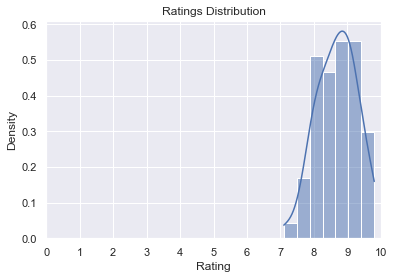

count    61.000000
mean      8.683607
std       0.598660
min       7.100000
25%       8.200000
50%       8.700000
75%       9.100000
max       9.800000
Name: imdb_rating, dtype: float64

In [418]:
sns.histplot(data['imdb_rating'], kde=True, stat="density")
plt.title('Ratings Distribution')
plt.xlabel('Rating')
plt.xticks(range(0, 11))

plt.show()

data['imdb_rating'].describe()

We can see that most of the TV show episodes have very high IMDb Ratings. <br>
Minimum rating value is 7.1 and the mean is 8.68. <br>
Half of the episodes received a rating of more than 8.7 and a quarter received more than 9.1. <br>
These are extremely good results and they show the love of viewers for the TV show

<h3 align='center'> Books and Chapters Ratings </h3>

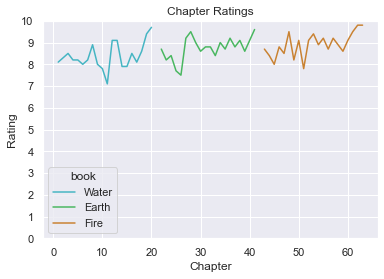

In [419]:
sns.lineplot(x='book_chapt', y='imdb_rating', hue='book', data=data,
             palette=['#45b5c3', '#49b760', '#c98232'])

plt.title('Chapter Ratings')
plt.xlabel('Chapter')
plt.ylabel('Rating')
plt.yticks(range(0, 11))

plt.show()

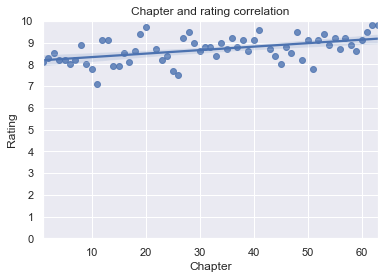

Ttest_indResult(statistic=9.827235525153414, pvalue=4.4353484124194516e-17)


In [420]:
sns.regplot(x='book_chapt', y='imdb_rating', data=data)
plt.title('Chapter and rating correlation')
plt.xlabel('Chapter')
plt.ylabel('Rating')
plt.yticks(range(0, 11))

plt.show()
print(stats.ttest_ind(data['book_chapt'], data['imdb_rating']))

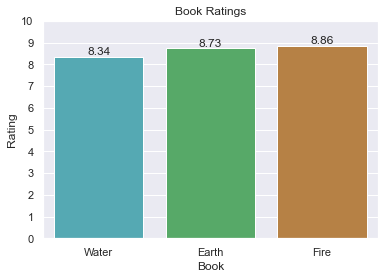

In [421]:
fig, ax = plt.subplots()

graph = sns.barplot(ax=ax, x='book', y='series_rating', data=data,
            palette=['#45b5c3', '#49b760', '#c98232'])
plt.title('Book Ratings')
plt.xlabel('Book')
plt.ylabel('Rating')
plt.yticks(range(0, 11))

for p in graph.patches:
    graph.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha='center', va='bottom')

plt.show()

Looking at the graph "Chapter and rating correlation" we can see a positive correlation between the episode number and its rating, so we can assume that the audience's opinion of the TV show has improved over time: the viewers enjoyed the show more and more as they continued watching it. <br>
Avatar's ratings increased from season to season and the final season had the highest rating of all. <br>
The story of Avatar came to a clear end, it had an epic conclusion and gave the audience an emotional attachment to the TV show as a real legend or saga. It may be the main factor in its popularity and the undying interest in it throughout all seasons

<h2 align='center'> Directors </h2>

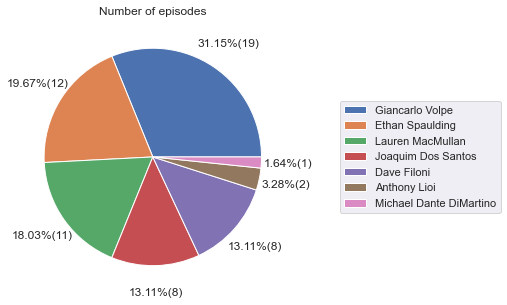

In [422]:
dir_episodes_cnt = engine.execute("""
                                  SELECT director, COUNT(1) AS episodes
                                  FROM data
                                  GROUP BY director
                                  ORDER BY episodes DESC
                                  """)
dir_episodes_cnt_df = pd.DataFrame(dir_episodes_cnt.fetchall())
dir_episodes_cnt_df.columns = dir_episodes_cnt.keys()

plt.figure(figsize=(8,5))

plt.pie(dir_episodes_cnt_df['episodes'], labels=None, pctdistance=1.25,
        autopct=lambda p: '{:.2f}%({:.0f})'.format(p, (p/100)*dir_episodes_cnt_df['episodes'].sum()))
plt.title("Number of episodes")
plt.legend(loc="center right", labels=dir_episodes_cnt_df['director'], bbox_to_anchor=(1.3, 0, 0.5, 1))
plt.grid()

plt.show()

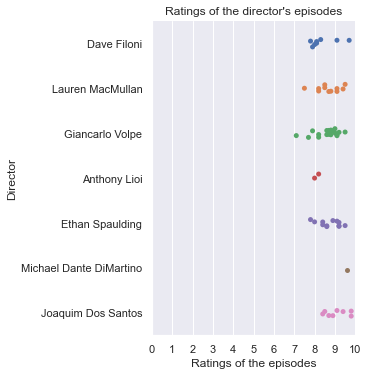

In [423]:
sns.catplot(x='imdb_rating', y='director', data=data)
plt.title('Ratings of the director\'s episodes')
plt.xlabel('Ratings of the episodes')
plt.ylabel('Director')
plt.xticks(range(0, 11))

plt.show()

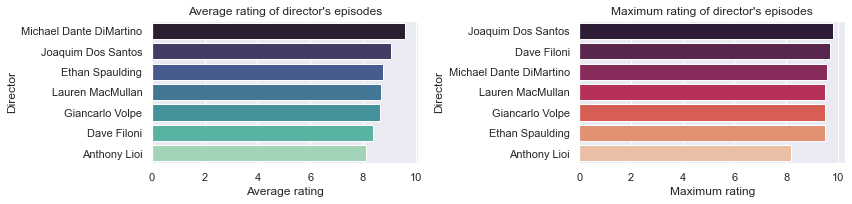

In [424]:
fig, ax = plt.subplots(1, 2, figsize=(12,3))

avg_rating = engine.execute("""
                            SELECT director, AVG(imdb_rating) AS rating
                            FROM data
                            GROUP BY director
                            ORDER BY rating DESC
                            """)
avg_rating_df = pd.DataFrame(avg_rating.fetchall())
avg_rating_df.columns = avg_rating.keys()

max_rating = engine.execute("""
                            SELECT director, MAX(imdb_rating) AS rating
                            FROM data
                            GROUP BY director
                            ORDER BY rating DESC
                            """)
max_rating_df = pd.DataFrame(max_rating.fetchall())
max_rating_df.columns = max_rating.keys()

sns.barplot(ax=ax[0], x='rating', y='director', data=avg_rating_df,
           palette='mako')
ax[0].set_xlabel('Average rating')
ax[0].set_ylabel('Director')
ax[0].set_title('Average rating of director\'s episodes')

sns.barplot(ax=ax[1], x='rating', y='director', data=max_rating_df,
           palette='rocket')
ax[1].set_xlabel('Maximum rating')
ax[1].set_ylabel('Director')
ax[1].set_title('Maximum rating of director\'s episodes')

fig.tight_layout()

plt.show()